<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "OLF"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/OLF/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


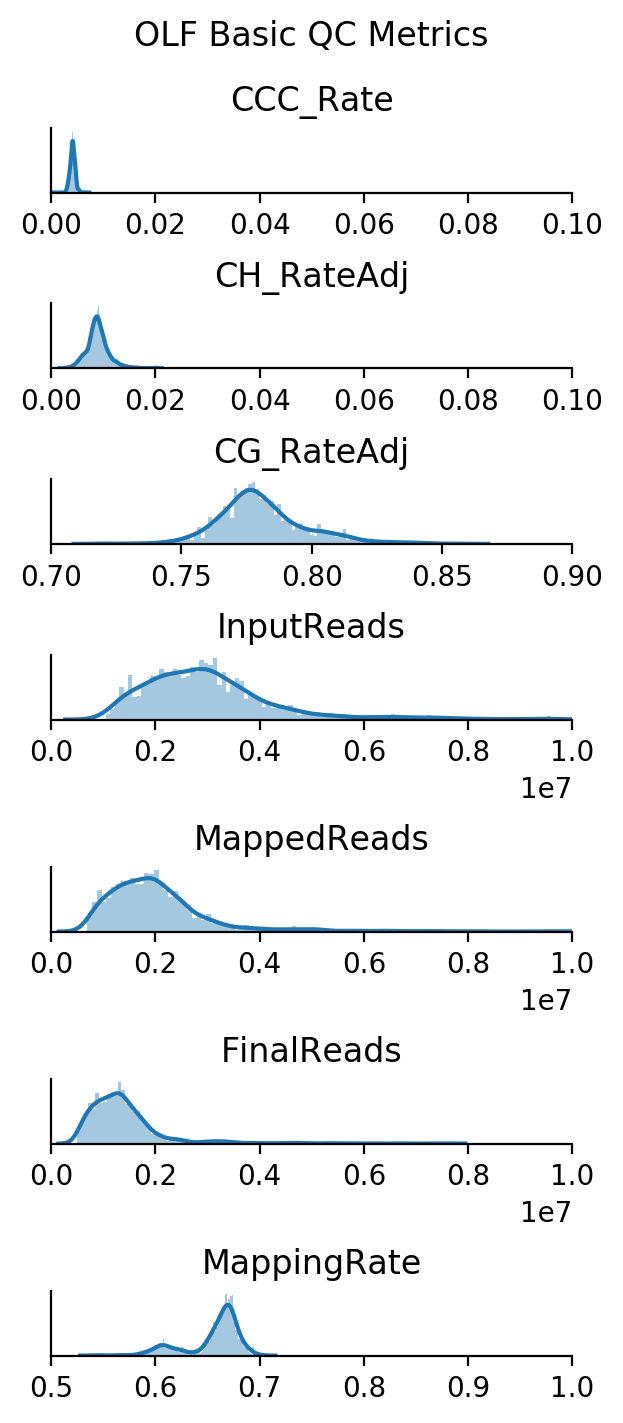

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

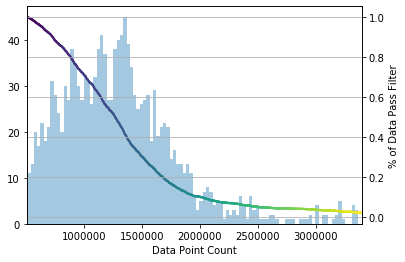

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 1452/1452 (100.0%)
CG_RateAdj passed 1452/1452 (100.0%)
CH_RateAdj passed 1452/1452 (100.0%)
FinalReads passed 1452/1452 (100.0%)
MappingRate passed 1452/1452 (100.0%)
Overall passed 1452/1452 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171214 1
171219 6
180109 2
180110 2
180119 3
180129 1
180206 1
180208 586
180212 407
180213 2
180220 141
180222 110
180226 2
180227 1
180305 1
180313 7
180319 7
180403 119
180405 2
180430 1
180806 1
180917 1
180925 2
181015 1
181016 2
181204 2
181210 1
181220 1
190205 1
190212 15
190214 5
190219 4
190305 5
190625 2
190711 7


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 199 51.8%
ad002 176 45.8%
ad004 191 49.7%
ad006 175 45.6%
ad007 190 49.5%
ad008 170 44.3%
ad010 181 47.1%
ad012 170 44.3%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_399,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.005042,0.778948,0.777828,0.016270,0.011285,1745554.0,4354786,2854510.0,10E,...,-2.149303,2.160301,-18.702945,28.520818,OLF,0.995736,-10.825104,-53.856237,-4.256740,True
10F_M_1318,/gale/raidix/rdx-4/mapping/10F/CEMBA190625-10F...,0.004478,0.763936,0.762874,0.012383,0.007940,2658109.0,7283248,4973334.0,10F,...,-2.134065,2.160300,-18.866025,28.616651,OLF,0.859205,-10.478794,-53.189288,-4.034641,True
11E_M_1736,/gale/raidix/rdx-4/mapping/11E/CEMBA190305-11E...,0.004072,0.789014,0.788152,0.013723,0.009690,2346454.0,6268924,4151407.0,11E,...,-2.099470,2.174920,-18.692091,28.509689,OLF,1.061450,-10.726473,-53.876939,-4.270948,True
11E_M_1931,/gale/raidix/rdx-4/mapping/11E/CEMBA190305-11E...,0.004675,0.783938,0.782923,0.014465,0.009837,2072110.0,5353988,3633669.0,11E,...,-2.120521,2.160490,-18.687475,28.529763,OLF,1.087156,-10.802289,-53.948585,-4.266255,True
11E_M_2210,/gale/raidix/rdx-4/mapping/11E/CEMBA190305-11E...,0.003432,0.778193,0.777429,0.009674,0.006264,2019715.0,5303024,3438026.0,11E,...,-2.132970,2.157271,-18.688352,28.520585,OLF,0.912359,-10.468980,-53.711211,-4.237220,True
11E_M_791,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.004812,0.786788,0.785757,0.014028,0.009261,1764574.0,4572206,2986380.0,11E,...,-2.086709,2.155283,-18.659548,28.513458,OLF,0.862069,-10.473438,-53.749500,-4.250960,True
11F_M_1457,/gale/raidix/rdx-4/mapping/11F/CEMBA190214-11F...,0.004660,0.772701,0.771637,0.014491,0.009877,1412303.0,3203268,2195004.0,11F,...,-2.186648,2.173279,-18.677585,28.525456,OLF,1.112796,-10.873726,-53.858226,-4.262829,True
11F_M_2472,/gale/raidix/rdx-4/mapping/11F/CEMBA190305-11F...,0.004857,0.772336,0.771225,0.016626,0.011827,2132221.0,4933046,3376763.0,11F,...,-2.129334,2.151055,-18.696186,28.529559,OLF,1.078567,-10.859391,-53.922812,-4.263116,True
11F_M_2973,/gale/raidix/rdx-4/mapping/11F/CEMBA190305-11F...,0.004706,0.764726,0.763614,0.014404,0.009743,906254.0,2139850,1427809.0,11F,...,-1.981930,2.149687,-18.641027,28.517936,OLF,0.921351,-10.506472,-53.685828,-4.254076,True
